## SETUP

In [2]:
import numpy as np
from numpy.fft import fft2, ifft2
import scipy as sp
import sigpy
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import pywt

import gfloat
from gfloat.formats import *
from gfloat import decode_float

c:\Users\greno\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


kspace: (8, 230, 180) complex64


EspiritCalib: 100%|██████████| 100/100 [00:00<00:00, 146.41it/s]


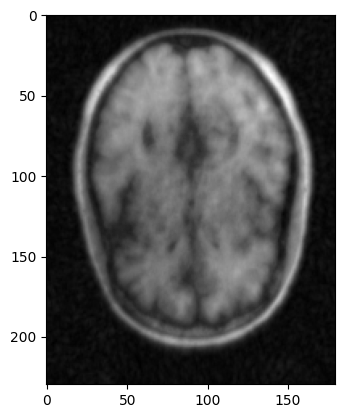

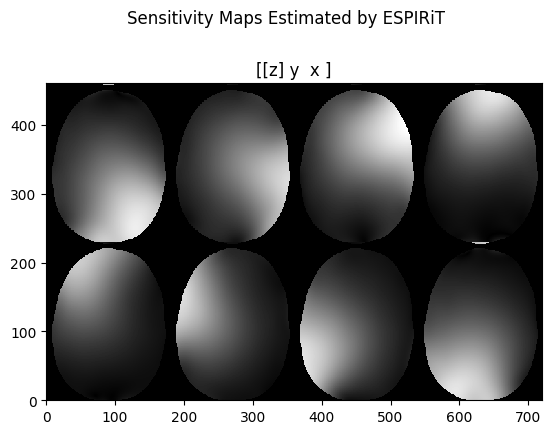

Sensitivity maps: (8, 230, 180) complex64


In [3]:
ksp_path = "../sigpy-mri-tutorial/data/"
ksp = np.load(ksp_path + 'cartesian_ksp.npy')
print('kspace:', ksp.shape, ksp.dtype)



img_mc = np.abs(sigpy.ifft(ksp, axes=(-1, -2))) # image space multicoil
img_rss = np.sum(img_mc**2, axis=0)**0.5
plt.imshow(img_rss, cmap='gray')

# get smaps
mps = mr.app.EspiritCalib(ksp).run()
pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
print('Sensitivity maps:', mps.shape, mps.dtype)

# Sigpy L1 Wavelet reconstruction

L1WaveletRecon: 100%|██████████| 100/100 [00:03<00:00, 29.58it/s, resid=8.58E-03]


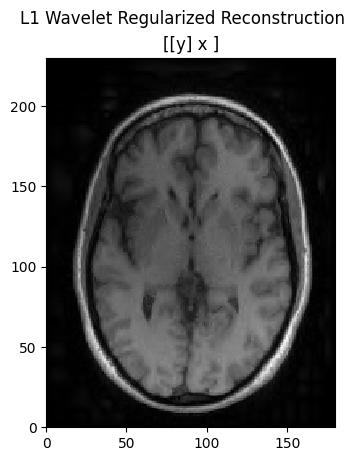

SenseRecon: 100%|██████████| 10/10 [00:00<00:00, 34.99it/s, resid=1.35E-01]


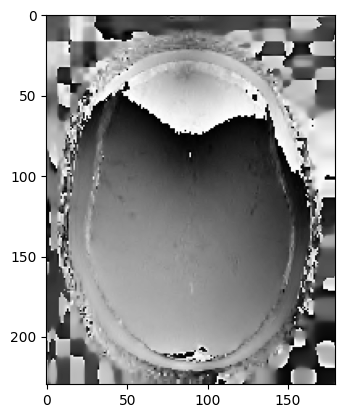

In [4]:
lamda = 0.005
img_l1wav = mr.app.L1WaveletRecon(ksp, mps, lamda).run()

pl.ImagePlot(img_l1wav, title='L1 Wavelet Regularized Reconstruction')
img_sense_32 = mr.app.SenseRecon(ksp, mps, lamda=lamda, solver='ConjugateGradient', max_iter=10).run()

plt.imshow(np.flip(np.angle(img_l1wav)), cmap='gray')

# Numpy L1 implementation

C:\Users\greno\AppData\Local\Temp\ipykernel_6920\4176025431.py:61: RuntimeWarning: invalid value encountered in divide
  sign = np.where(np.abs(x) == 0, 0, x/np.abs(x))


(np.float64(-0.5), np.float64(179.5), np.float64(229.5), np.float64(-0.5))

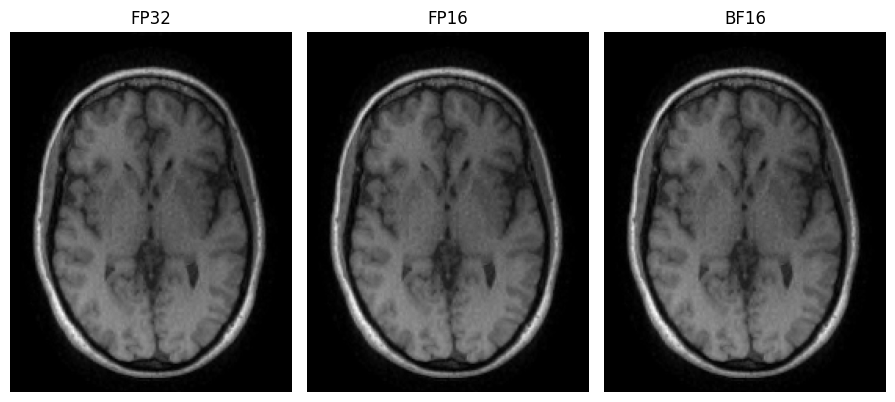

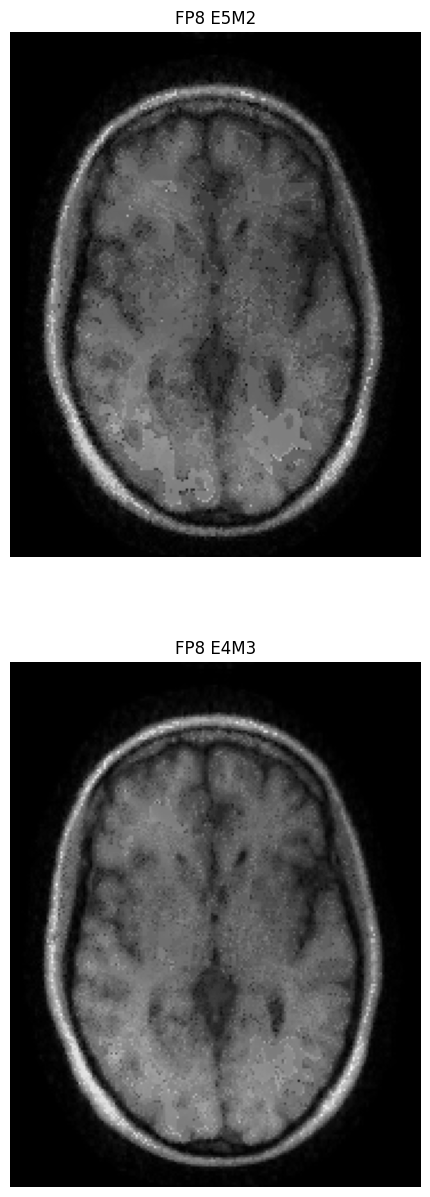

In [8]:
# L1 Wavelet Reconstruction in numpy

def to_fp8(x, format=format_info_ocp_e5m2):
    fp8_real = gfloat.round_ndarray(format, x.real) #format_info_ocp_e4m3 
    fp8_imag = gfloat.round_ndarray(format, x.imag)
    fp8_complex = fp8_real + 1j * fp8_imag
    return fp8_complex

def to_fp16(x):
    real_part = x.real.astype(np.float16)
    imag_part = x.imag.astype(np.float16)
    return real_part + 1j * imag_part

def l1_sense_reconstruction(kspace, sensitivity_maps, num_iters=100, lamda=1e-2, tol=1e-6, use_fp16=False, use_fp8=False, format=format_info_binary32):
    ishape = (kspace.shape[1], kspace.shape[2]) # image shape
    
    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)
    
    W = get_weights(kspace)

    if use_fp16:
        W = to_fp16(W)
        kspace = to_fp16(kspace)
        sensitivity_maps = to_fp16(sensitivity_maps)
    elif use_fp8:
        W = to_fp8(W, format=format)
        kspace = to_fp8(kspace, format=format)
        sensitivity_maps = to_fp8(sensitivity_maps, format=format)

    def forward_op(x):
        #return A(x)
        """Forward operation: SENSE forward model."""
        shifted_image = np.fft.fftshift(x*sensitivity_maps, axes=(-2,-1)) # need to shift
        res =  np.fft.fft2(shifted_image, ishape, norm='ortho', axes=(-2,-1))
        res = W**0.5 * res

        if use_fp16:
            res = to_fp16(res)
        elif use_fp8:
            res = to_fp8(res, format=format)
        
        return res
    
    # x* FHSH
    def adjoint_op(y):
        #return A.H(y)
        """Adjoint operation: SENSE adjoint model."""
        ifft_result = np.fft.ifft2(W**0.5*y, ishape, norm='ortho',  axes=(-2,-1))
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(-2,-1)) # need to shift
        res = np.sum(np.conj(sensitivity_maps) * shifted_ifft_result, axis=0)

        if use_fp16:
            res = to_fp16(res)
        elif use_fp8:
            res = to_fp8(res, format=format)

        return res

    def soft_threshold(x, lamda):
        sign = np.where(np.abs(x) == 0, 0, x/np.abs(x))
        mag = np.abs(x) - lamda
        mag = (np.abs(mag) + mag)/2
        return sign * mag
    
    def g(x, alpha):
        
        # Wavelet transform
        zshape = [((i + 1) // 2) * 2 for i in x.shape]
        zinput = np.resize(x, zshape)
        coeffs = pywt.wavedecn(zinput, 'db4', mode='zero', axes=(-2,-1))
        w, coeff_slices = pywt.coeffs_to_array(coeffs, axes=(-2,-1))
        # proximal operator for L1 norm
        prox = soft_threshold(w, alpha*lamda)
        
        # Inverse Wavelet transform
        inv_input = pywt.array_to_coeffs(prox, coeff_slices, output_format='wavedecn')
        recn = pywt.waverecn(inv_input, 'db4', mode='zero', axes=(-2,-1))

        if use_fp16:
            recn = to_fp16(recn)
        elif use_fp8:
            recn = to_fp8(recn, format=format)

        return recn

    # Define AHA operator: A^H A + lambda I
    def normal_op(x):
        #return x + lamda * x
        """Normal equation operator: A^H A + lambda L1 norm"""
        result = adjoint_op(forward_op(x)) + lamda*x

        if use_fp16:
            return to_fp16(result)
        elif use_fp8:
            return to_fp8(result, format=format)
        
        return result
    
    b = adjoint_op(W**0.5 * kspace)
    x = np.zeros_like(b)  # 0s init
    r = np.zeros_like(b)  # 0s init

    alpha = 1
    # gradient descent iterations
    for i in range(num_iters):
        x_old = x.copy()

        if use_fp16:
            r = to_fp16(normal_op(x) - b + lamda*x)
        elif use_fp8:
            r = to_fp8(normal_op(x) - b + lamda*x, format=format)
        else:   
            r = normal_op(x) - b + lamda*x
        
        x = g(x - alpha * r, alpha)
        resid = np.linalg.norm(x-x_old)/alpha

        if use_fp16:
            resid = to_fp16(resid)
        elif use_fp8:
            resid = to_fp8(resid, format=format)

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break
        

    return x


recon_img = l1_sense_reconstruction(ksp, mps, num_iters=25, lamda=0.005)
recon_img_fp16 = l1_sense_reconstruction(ksp, mps, num_iters=25, lamda=0.005, use_fp8=True, format=format_info_binary16) 
recon_img_bf16 = l1_sense_reconstruction(ksp, mps, num_iters=25, lamda=0.005, use_fp8=True, format=format_info_bfloat16) 
recon_img_fp8_e5m2_0p1 = l1_sense_reconstruction(ksp, mps, num_iters=10, lamda=0.005, use_fp8=True, format=format_info_ocp_e5m2)  
recon_img_fp8_e4m3_0p1 = l1_sense_reconstruction(ksp, mps, num_iters=10, lamda=0.005, use_fp8=True, format=format_info_ocp_e4m3)


plt.figure(figsize=(15,15))
plt.subplot(151)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
plt.title('FP32')
plt.axis('off')
plt.subplot(152)
plt.imshow(np.abs(np.flip(recon_img_fp16)), cmap='gray')
plt.title('FP16')
plt.axis('off')
plt.subplot(153)
plt.imshow(np.abs(np.flip(recon_img_bf16)), cmap='gray')
plt.title('BF16')
plt.axis('off')
plt.tight_layout()

plt.figure(figsize=(15,15))
plt.subplot(211)
plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p1)), cmap='gray')
plt.title('FP8 E5M2')
plt.axis('off')
plt.subplot(212)
plt.imshow(np.abs(np.flip(recon_img_fp8_e4m3_0p1)), cmap='gray')
plt.title('FP8 E4M3')
plt.axis('off')

In [ ]:
import time

# Rough theoeretical calculation of flops for L1 Sense reconstruction
def flops(ksp, mps, iterations=100, use_fp16=False, use_fp8=False, format=format_info_ocp_e5m2):
    num_coil = ksp.shape[0]
    nrows, ncols = ksp.shape[1], ksp.shape[2]

    N = nrows * ncols # number of elements/pixels in image
    wavelet_length = 8 # db4 wavelet has 8 coefficients
    dwt_flops =  2 * N * wavelet_length # DWT is basically a convolution
    soft_thresh_flops =  5 * N # 5 flops per element in soft threshold
    idwt_flops =  2 * N * wavelet_length # Same as DWT
    g_flops = dwt_flops + soft_thresh_flops + idwt_flops # g function/ wavelet operator

    fft_flops = 5 * N * np.log2(N) # 5 flops per element in FFT according to some sources
    adjoint_flops = num_coil * (fft_flops + N + 2 * N) # scale by weights, FFT and sum, scale with sensitivity maps
    forward_flops = fft_flops + N + N # FFT, sensitivity maps and scale by weights

    total_flops = iterations * (5 * N + g_flops + adjoint_flops + forward_flops) # 5 N from vector addition and scalar multiplication in the main loop
    
    t1 = time.perf_counter()
    recon_img = l1_sense_reconstruction(ksp, mps, num_iters=iterations, lamda=0.005, use_fp16=use_fp16, use_fp8=use_fp8, format=format)
    t2 = time.perf_counter()
    total_time = t2 - t1
    
    print("Total FLOPs for {:.2e} iterations: {}".format(iterations, total_flops))
    print("Total time: {:.2e}".format(total_time))
    print("FLOPs per second: {:.2e}".format(total_flops / total_time))
    return total_flops

num_iters = 25

print("FP32")
flops(ksp, mps, iterations=num_iters)

print("FP16")
flops(ksp, mps, iterations=num_iters, use_fp16=True)

print("BF16")
flops(ksp, mps, iterations=num_iters, use_fp8=True, format=format_info_bfloat16)

print("FP8 E5M2")
flops(ksp, mps, iterations=num_iters, use_fp8=True, format=format_info_ocp_e5m2)

print("FP8 E4M3")
flops(ksp, mps, iterations=num_iters, use_fp8=True, format=format_info_ocp_e4m3)


FP32


C:\Users\greno\AppData\Local\Temp\ipykernel_6920\4176025431.py:61: RuntimeWarning: invalid value encountered in divide
  sign = np.where(np.abs(x) == 0, 0, x/np.abs(x))


Total FLOPs for 2.50e+01 iterations: 784716757.084289
Total time: 5.71e-01
FLOPs per second: 1.37e+09
FP16
Total FLOPs for 2.50e+01 iterations: 784716757.084289
Total time: 6.98e-01
FLOPs per second: 1.12e+09
BF16
Total FLOPs for 2.50e+01 iterations: 784716757.084289
Total time: 3.27e+00
FLOPs per second: 2.40e+08
FP8 E5M2
Total FLOPs for 2.50e+01 iterations: 784716757.084289
Total time: 3.43e+00
FLOPs per second: 2.29e+08
FP8 E4M3
Total FLOPs for 2.50e+01 iterations: 784716757.084289
Total time: 3.76e+00
FLOPs per second: 2.09e+08


np.float64(784716757.084289)